In [2]:
import sys
sys.path.insert(0,'C:\\code\\masters_thesis\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import minimize

"""
Own packages
"""

from codelib.population_parameters import calculate_mean, calculate_cov_mat
from codelib.portfolio_measures import portfolio_mean, portfolio_variance, portfolio_std
from codelib.portfolio_performance_measures import sharpe_ratio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load datasets (monthly return timeseries)

In [73]:
# load data (for now sp500 monthly return premiums from 1991-1-1 to 2023-1-1)
monthly_return_premiums = pd.read_csv(r'C:\code\masters_thesis\data\sp500_monthly_return_premiums.csv', index_col='Date')
data = monthly_return_premiums
assets = data.columns
data.tail()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
2022-08,-2.08,-5.96,-3.67,3.13,-5.37,-3.20,-3.31,-5.26,-0.10,-3.01
2022-09,-8.51,-6.87,-11.70,-9.31,-11.59,-14.13,-7.80,-2.10,-11.84,-8.10
2022-10,9.71,-6.50,11.99,23.37,4.62,10.71,4.07,8.61,3.27,11.37
2022-11,4.98,-7.86,8.73,0.68,4.95,2.03,3.57,5.17,6.53,5.71
2022-12,-3.00,-27.80,-2.69,-4.49,-8.21,-7.09,-8.29,-2.06,-1.48,-5.60


# Estimate rolling input parameters

In [63]:
# set variables (length of rolling estimation window)
M = 60
rol_mean = data.rolling(window=M).mean().dropna(inplace=False)
rol_cov_mat = data.rolling(window=M).cov().dropna(inplace=False)

In [64]:
rol_mean

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1995-12,0.922667,1.164667,1.102833,0.578333,1.525167,0.993167,0.921000,1.058500,0.654333,1.424000
1996-01,0.882833,1.103000,1.052333,0.607333,1.309667,1.030167,0.760833,1.085000,0.709667,1.360000
1996-02,0.764833,0.967667,0.971333,0.484167,1.309833,0.938167,0.697167,0.903333,0.586667,1.236333
1996-03,0.670333,1.020500,1.008000,0.546167,1.241000,0.869000,0.654667,0.817000,0.550333,1.214667
1996-04,0.689333,1.119833,1.027667,0.563333,1.457333,0.896500,0.694000,0.827000,0.507500,1.198833
...,...,...,...,...,...,...,...,...,...,...
2022-08,0.525833,2.466500,0.720500,1.440333,1.437000,0.192833,1.253167,0.671833,0.718500,0.795833
2022-09,0.391000,2.265500,0.457500,1.104167,1.234500,-0.013333,1.084167,0.604167,0.555500,0.589667
2022-10,0.552833,2.137833,0.612167,1.487000,1.198333,0.261333,1.108167,0.787000,0.560333,0.746000


In [65]:
rol_cov_mat

NoDur      Durbl      Manuf      Enrgy      HiTec  \
Date                                                                   
1995-12 NoDur  13.445752   6.180550   8.327384   4.610598   9.593950   
        Durbl   6.180550  25.399947  11.585202   4.383377  10.840521   
        Manuf   8.327384  11.585202  10.432621   5.129829  10.378878   
        Enrgy   4.610598   4.383377   5.129829  13.093089   3.569422   
        HiTec   9.593950  10.840521  10.378878   3.569422  20.757066   
...                  ...        ...        ...        ...        ...   
2022-12 Telcm  20.567911  34.648142  26.576494  38.984436  24.718085   
        Shops  19.261901  56.661866  28.502247  33.107342  34.617180   
        Hlth   15.016846  33.082733  22.056733  27.109145  23.310445   
        Utils  15.257373  23.425855  19.037430  23.309015  16.312747   
        Other  24.646223  52.174208  35.336986  52.316916  32.811202   

                   Telcm      Shops       Hlth      Utils      Other  
Date                                                                  
1995-12 NoDur   5.863451  11.855867  13.071426   4.580676   8.979728  
        Durbl   4.890163   9.053951   4.573682   1.173473  10.992315  
        Manuf   5.412962   9.194982   9.496292   2.162877   9.446733  
        Enrgy   6.447412   2.712664   4.470494   5.892558   5.825269  
        HiTec   4.386539  11.635205  10.894432   0.737245  10.488537  
...                  ...        ...        ...        ...        ...  
2022-12 Telcm  30.235593  21.763156  18.220184  15.251164  28.411147  
        Shops  21.763156  34.652559  21.639791  16.077005  29.061602  
        Hlth   18.220184  21.639791  22.401162  11.552943  21.820914  
        Utils  15.251164  16.077005  11.552943  22.398227  18.068813  
        Other  28.411147  29.061602  21.820914  18.068813  38.533703  

[3250 rows x 10 columns]

In [66]:
# turn multiindex dataframe of rolling cov matrices into array
T = len(rol_mean)
rol_cov_mat_arr = rol_cov_mat.values.reshape(T, 10, 10)
rol_mean_arr = np.array(rol_mean)
print(rol_cov_mat_arr[0])
rol_mean_arr[0]

[[13.44575209  6.18055006  8.32738384  4.61059774  9.5939504   5.86345073
  11.85586678 13.0714261   4.58067638  8.97972814]
 [ 6.18055006 25.39994734 11.58520181  4.3833774  10.84052124  4.89016294
   9.05395119  4.57368169  1.17347266 10.99231492]
 [ 8.32738384 11.58520181 10.43262065  5.12982853 10.37887833  5.41296206
   9.19498186  9.49629246  2.16287734  9.44673254]
 [ 4.61059774  4.3833774   5.12982853 13.0930887   3.56942232  6.44741215
   2.71266441  4.47049407  5.89255819  5.82526949]
 [ 9.5939504  10.84052124 10.37887833  3.56942232 20.75706607  4.38653929
  11.63520492 10.89443161  0.73724503 10.48853661]
 [ 5.86345073  4.89016294  5.41296206  6.44741215  4.38653929 10.14740167
   4.85933237  6.34157941  5.69210638  7.47131254]
 [11.85586678  9.05395119  9.19498186  2.71266441 11.63520492  4.85933237
  16.2660939  11.34079983  2.02528881 10.35733492]
 [13.0714261   4.57368169  9.49629246  4.47049407 10.89443161  6.34157941
  11.34079983 23.10995534  4.08311339 10.08491288]


array([0.92266667, 1.16466667, 1.10283333, 0.57833333, 1.52516667,
       0.99316667, 0.921     , 1.0585    , 0.65433333, 1.424     ])

# Estimate optimal weights

In [118]:
# solve for optimal mean-variance weights dependent on re-balancing interval (num_reb, number of re-balancing days each year)

num_reb = 12
reb_int = int(12/num_reb)
rf = 0

w_m_rol = list()

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1, 'jac' : lambda w: np.ones_like(w)},
               {'type': 'ineq', 'fun' : lambda w: w, 'jac' : lambda w: np.eye(len(w))})

equal_weights = np.repeat(1,10) / 10  #use variabel instead of hardcoding 10

for t in range(len(rol_mean_arr[0::reb_int])):

    res = minimize(fun = sharpe_ratio, args=(rol_mean_arr[t], rol_cov_mat_arr[t], rf),
                   x0 = equal_weights,
                   method = 'SLSQP',
                   constraints = constraints)
    w_m_rol.append(np.repeat(res.x, reb_int))
    #w_m_rol.extend(res.x * reb_int)

w_m_rol = np.array(w_m_rol)

In [119]:
w_m_rol

array([[-2.00900734e-17,  5.16011543e-18, -2.55651016e-17, ...,
         2.54903453e-17,  1.78724915e-01,  3.77091715e-01],
       [ 2.67294505e-17, -1.08494294e-17, -6.66444464e-17, ...,
         1.11737554e-17,  1.84863653e-01,  3.89433650e-01],
       [-5.77459737e-19, -3.04059065e-17, -3.07289758e-17, ...,
        -4.85921713e-17,  1.51247468e-01,  4.04895631e-01],
       ...,
       [-9.68844194e-17,  1.59359321e-01,  1.62288393e-17, ...,
         2.10575221e-01,  2.72356476e-02, -8.42029497e-17],
       [-3.26844323e-17,  6.78926198e-02, -5.72249602e-17, ...,
         2.36307133e-01,  1.27767343e-01,  2.47865194e-17],
       [-2.80898524e-16, -2.24630023e-16, -3.12984766e-16, ...,
         3.29309386e-01,  3.05348956e-01, -1.25309505e-16]])

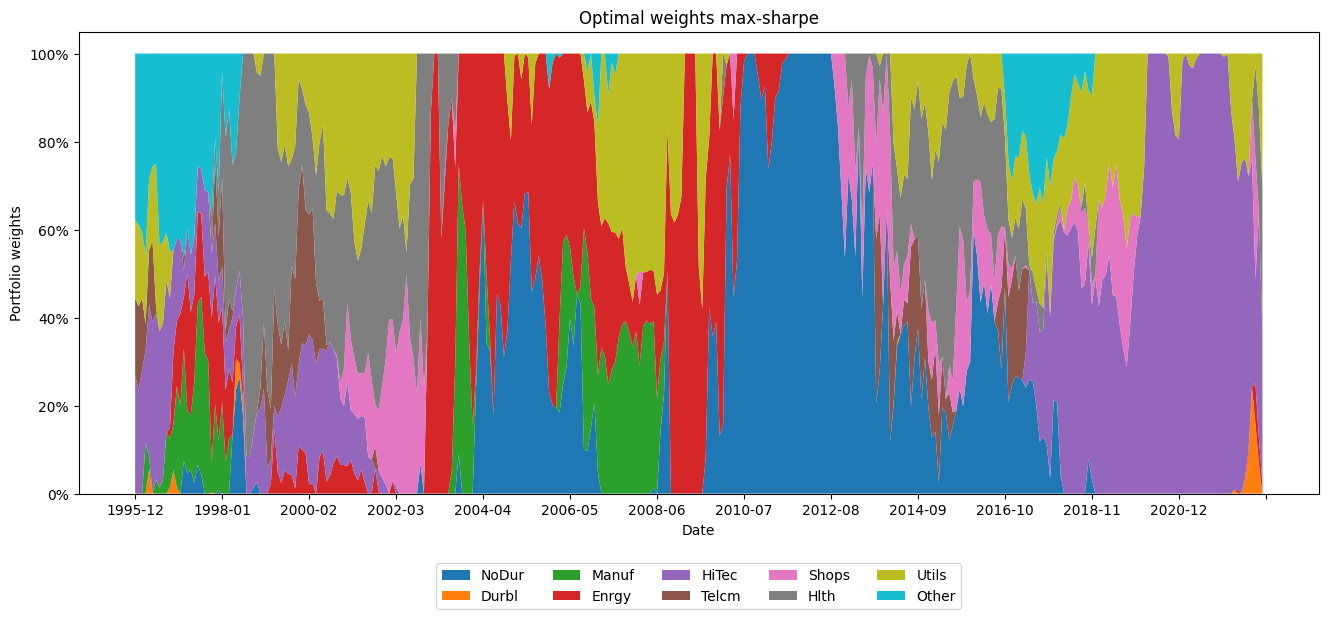

In [113]:
# plot optimal weights

fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(rol_mean.index[0::reb_int], w_m_rol.T, labels=assets);
#ax.xaxis.set_major_formatter(ticker)
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=False, ncol=5)
ax.set_xlabel("Date")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights max-sharpe");

# Calculate out-of-sample returns

In [120]:
# remove last row of optimal weights (can't apply weights from 31-12-2022 on january 2023 as I don't have realized returns for this month)

w_m_rol = w_m_rol[:-1]
w_m_rol

array([[-2.00900734e-17,  5.16011543e-18, -2.55651016e-17, ...,
         2.54903453e-17,  1.78724915e-01,  3.77091715e-01],
       [ 2.67294505e-17, -1.08494294e-17, -6.66444464e-17, ...,
         1.11737554e-17,  1.84863653e-01,  3.89433650e-01],
       [-5.77459737e-19, -3.04059065e-17, -3.07289758e-17, ...,
        -4.85921713e-17,  1.51247468e-01,  4.04895631e-01],
       ...,
       [ 1.11352202e-17,  2.41313761e-01,  6.56924934e-18, ...,
        -6.20490886e-17,  1.06184576e-01,  1.63168301e-18],
       [-9.68844194e-17,  1.59359321e-01,  1.62288393e-17, ...,
         2.10575221e-01,  2.72356476e-02, -8.42029497e-17],
       [-3.26844323e-17,  6.78926198e-02, -5.72249602e-17, ...,
         2.36307133e-01,  1.27767343e-01,  2.47865194e-17]])

In [154]:
returns_m = np.sum(data[M:] * w_m_rol, axis=1)

In [155]:
returns_m

Date
1996-01     2.172086
1996-02     1.041540
1996-03    -1.028061
1996-04     1.686875
1996-05     1.750676
             ...    
2022-08    -4.137577
2022-09   -11.239729
2022-10     1.719036
2022-11     2.228792
2022-12    -7.014045
Length: 324, dtype: float64

<AxesSubplot:xlabel='Date'>

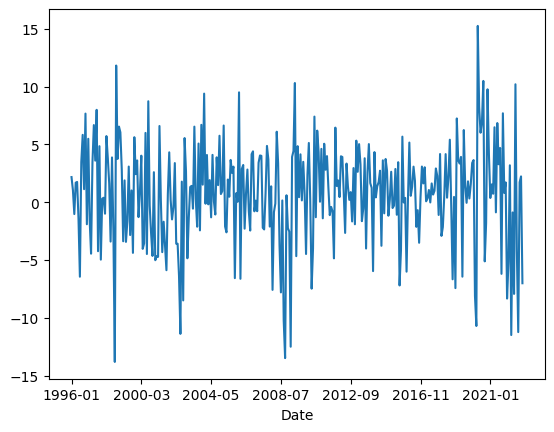

In [156]:
returns_m.plot()

In [160]:
np.cumprod(1 + returns_m/100)

Date
1996-01    1.021721
1996-02    1.032362
1996-03    1.021749
1996-04    1.038985
1996-05    1.057174
             ...   
2022-08    7.367052
2022-09    6.539015
2022-10    6.651423
2022-11    6.799670
2022-12    6.322738
Length: 324, dtype: float64

In [177]:
# calcualte wealth evolution

m_index = np.ones(len(returns_m) + 1)
m_index
m_index[1:] = np.cumprod(1 + returns_m/100)

In [178]:
m_index

array([1.        , 1.02172086, 1.03236249, 1.02174918, 1.03898482,
       1.05717408, 1.04200785, 0.97480904, 1.00854595, 1.06729236,
       1.07929537, 1.16200604, 1.13980972, 1.20233239, 1.18362783,
       1.13089133, 1.16969313, 1.24772164, 1.29258407, 1.39585511,
       1.3366354 , 1.4013841 , 1.3317308 , 1.33575142, 1.34085034,
       1.32749334, 1.40340834, 1.45691836, 1.48046877, 1.43000811,
       1.48537804, 1.44827937, 1.24810785, 1.39565841, 1.44788095,
       1.54253783, 1.63574129, 1.68184755, 1.62495943, 1.65558401,
       1.59870673, 1.57226796, 1.62072141, 1.57464419, 1.59060249,
       1.52084976, 1.60635391, 1.64530584, 1.70472972, 1.68270621,
       1.69749107, 1.76577768, 1.69449128, 1.6341885 , 1.73212805,
       1.65445419, 1.79891017, 1.7935852 , 1.74534319, 1.66417815,
       1.70735202, 1.62162235, 1.5458245 , 1.47275129, 1.56980369,
       1.57227071, 1.50429058, 1.47886182, 1.42188349, 1.33820549,
       1.34759811, 1.40572568, 1.40853915, 1.38753988, 1.38132

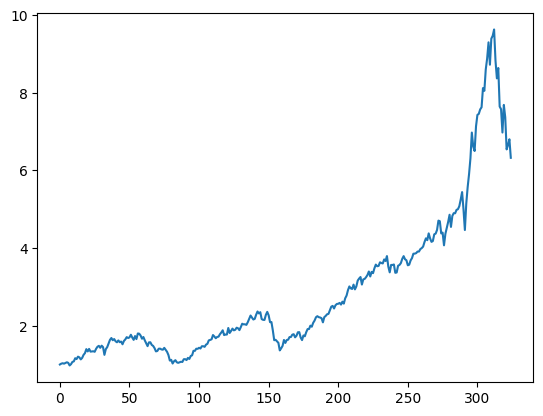

In [180]:
plt.plot(m_index)